## ana_proj_uv
read data of projected horizontal velocity and check that it seems OK

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#from glob import glob
from pathlib import Path
import os, time

import numpy as np

import xarray as xr
#from xorca.lib import load_xorca_dataset
from xgcm import Grid

#from itidenatl.nemodez import Vmodes
#import itidenatl.eos as eos
#import itidenatl.vars as var
#import itidenatl.gridop as gop
import itidenatl.utils as ut

In [2]:
from dask.distributed import Client, LocalCluster, wait
cluster = LocalCluster(n_workers=8) #n_workers=24, threads_per_worker=1, memory_limit=8e6,silence_logs=50
client = Client(cluster)
client

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37480 instead
  expected, actual


Client Scheduler: tcp://127.0.0.1:44464 Dashboard: http://127.0.0.1:37480/status,Cluster Workers: 8 Cores: 56 Memory: 236.33 GiB


In [7]:
### define paths
scratch = Path(os.getenv("SCRATCHDIR"))
workdir = Path("/work/CT1/ige2071/nlahaye")
worksha = (workdir/"../SHARED").resolve()

var = "v"
i_day = 96
i_mod = 1

vmod_path = worksha/"vmodes/vmodes_10.zarr"
#ssh_path = Path("/store/albert7a/eNATL60/zarr/eNATL60-BLBT02-SSH-1h") # zarr
grid_path = scratch/"mesh_mask_eNATL60_3.6.nc"
modamp_dir = worksha/"modal_proj/modamp_{}".format(var)
modamp_nam = "modamp_{}_global_{}.zarr".format(var, "{}")


In [8]:
ladate = ut.get_date_from_iday(i_day)

ds = xr.open_zarr(modamp_dir/modamp_nam.format(ladate))
varname = [k for k in ds.data_vars][0]

chks = {k[0]:v[0] for k,v in ds.chunks.items() if k in ["x_c", "y_c", "x_r", "y_r"]}

for c in ["llon_cc", "llat_cc"]:
    ds = ds.assign_coords({c.rstrip("_cc"):ut.open_one_coord(grid_path, chunks=chks, varname=c)[c]})
ds

dim = "xy"["uv".index(var)]
ds = ds.assign_coords({dim+"_c": ds[dim+"_c"]+1})
ds[dim+"_c"].attrs["axis"] = dim.upper()

grid = Grid(ds)

for c in ["llon", "llat"]:
    ds[c] = grid.interp(ds[c], dim.upper(), boundary="extrapolate").chunk({dim+"_r":chks[dim]})
ds = ds.drop_dims(dim+"_c")

mask=~xr.ufuncs.isnan(ds[varname].isel(t=0, mode=0)).reset_coords(drop=True).persist()
ds = ds.assign_coords(mask=mask)

ds

<xarray.Dataset>
Dimensions:   (mode: 11, t: 24, x_c: 8354, y_r: 4729)
Coordinates:
  * mode      (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * t         (t) datetime64[ns] 2009-10-04T00:30:00 ... 2009-10-04T23:30:00
  * x_c       (x_c) float32 1.0 2.0 3.0 4.0 ... 8.352e+03 8.353e+03 8.354e+03
  * y_r       (y_r) float32 1.5 2.5 3.5 4.5 ... 4.728e+03 4.728e+03 4.73e+03
    llon      (y_r, x_c) float32 dask.array<chunksize=(400, 8354), meta=np.ndarray>
    llat      (y_r, x_c) float32 dask.array<chunksize=(400, 8354), meta=np.ndarray>
    mask      (y_r, x_c) bool dask.array<chunksize=(400, 8354), meta=np.ndarray>
Data variables:
    vomecrty  (t, y_r, x_c, mode) float32 dask.array<chunksize=(24, 400, 8354, 1), meta=np.ndarray>
Attributes:
    by:                 N. Lahaye (noe.lahaye@inria.fr)
    date generated:     Thu Sep  2 15:52:09 2021
    day of simulation:  20091004
    from_files:         /scratch/cnt0024/ige2071/nlahaye/eNATL60_grid_vmodes_...
    generating_script:  proj_uv_ty-loop.12216166.py
    i_day:              96
    simulation:         eNATL60 (with tides)

In [9]:
it, imod = 12, 1
slih = slice(0,None,10)
sds = ds.isel({d:slih for d in ds.dims if d[0] in "xy"})
amod_moy = sds[varname].isel(mode=imod).mean("t").persist()
toplot = (sds[varname].isel(mode=imod,t=it)-amod_moy).persist()

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


CPU times: user 705 ms, sys: 105 ms, total: 810 ms
Wall time: 3.46 s


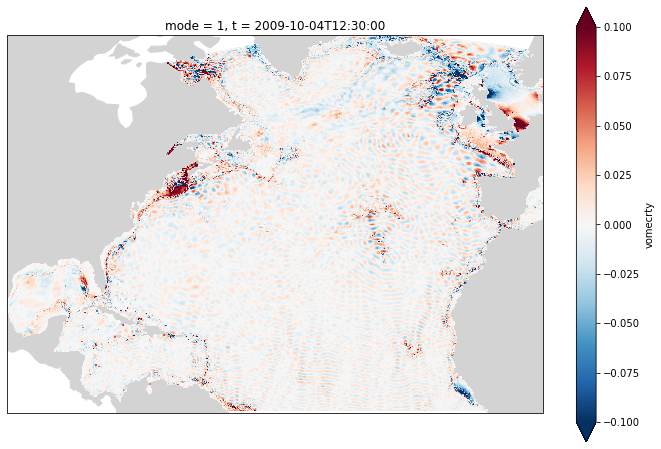

In [10]:
%%time
#map_proj = ccrs.LambertConformal(central_longitude=-28, central_latitude=39)
map_proj = ccrs.Robinson(central_longitude=-50)
norm = mpl.colors.Normalize(vmin=-.1, vmax=.1)
cmap = "RdBu_r"

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=map_proj)
#ax.coastlines()
#gl = ax.gridlines()
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.set_extent([-97, -1, 6, 58])
p = toplot.squeeze().plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                     x="llon", y="llat", 
                                    norm=norm, cmap=cmap)
#ax.set_aspect('equal', 'box-forced') # this raises an error


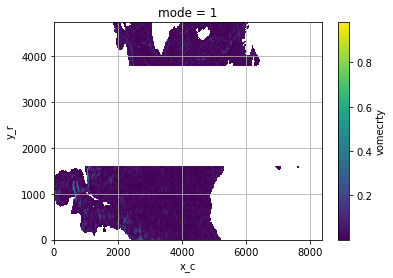

In [12]:
abs(amod_moy).plot()
plt.grid(True)

CPU times: user 16.5 s, sys: 5.23 s, total: 21.7 s
Wall time: 21 s


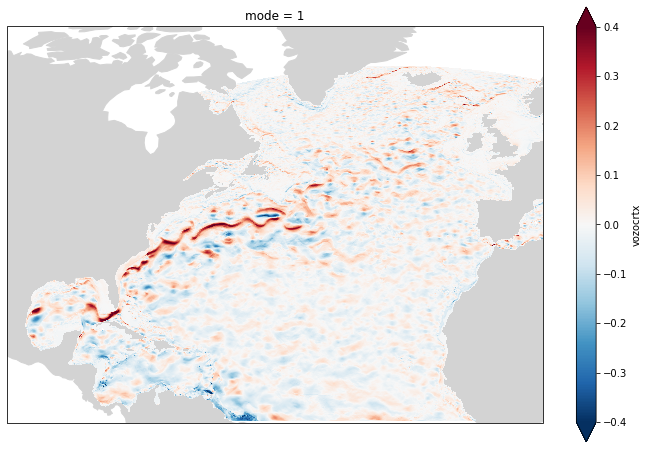

In [7]:
%%time
#map_proj = ccrs.LambertConformal(central_longitude=-28, central_latitude=39)
map_proj = ccrs.Robinson(central_longitude=-28)
norm = mpl.colors.Normalize(vmin=-.4, vmax=.4)
cmap = "RdBu_r"

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=map_proj)
#ax.coastlines()
#gl = ax.gridlines()
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.set_extent([-100, 2, 6, 68])
p = amod_moy.squeeze().plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                     x="llon", y="llat", 
                                    norm=norm, cmap=cmap)
#ax.set_aspect('equal', 'box-forced') # this raises an error


In [7]:
### harmonic extraction
time = (ds.t - ds.t[0]).dt
time = time.days*24. + time.seconds/3600. 

ds = ds.assign_coords(time=time.persist())
ds.time.values

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [8]:
### define a window function

def planck_taper_ext(t, T=1., eps=.1, t0=0., normalized=True):
    """ planck taper window with transient centered at window length 
    quick and dirty implementation. Window is  centered
    planck taper with standard definition: transient centered at -T(.5-eps), T*(.5-eps). 
    extending time to T/(1-eps) make the interval between transient center equals T.
    return normalized window such that sum is 1 """
    #print("bornes, T, eps, t0:", t.min(), t.max(), T, eps, t0)
    if eps>=.5:
        raise ValueError("need eps<.5. Passed value is {:.2f}".format(eps))
    t = (t-t0)/T*(1.-eps) # use coordinate mapping: stretching 
    t1, t4 = -.5, .5
    win = np.where((t>t1) * (t<t4), 1., 0.)
    if eps > 0.:
        t2 = (eps-.5)
        t3 = (.5-eps)
        z_t = np.where(t<0., (t2-t1)/(t-t1) + (t2-t1)/(t-t2), (t3-t4)/(t-t3) + (t3-t4)/(t-t4))
        win = np.where((t<t2) + (t>t3), win/(np.exp(z_t)+1.), win)

    if normalized and win.max()>0.:
        win /= win.sum()
        
    return win


In [9]:
### Define periods and stuff
dt = float(ds.time.diff("t").mean())
f = 1./12.22
omega = 2*np.pi*f
eps_win = .4# relative length (in periods) of transient for time window
n_per = 1 # number of targeted periods / window
n_win = int(round( ((n_per+eps_win))/f/dt))
print("n_win :", n_win)

### harmonic extraction
# create rolling object and construt: window index is a new dim, "t_win"
def get_harmo(data, mask=None):
    if mask is None and mask is not False and "mask" in data.coords:
        mask = data.mask
    else:
        mask = None
    da_in = data.chunk({"t":-1})
    da_rol = da_in * xr.ufuncs.exp(-1.j*omega*da_in.time)
    da_rol = da_rol.rolling(t=n_win, center=True).construct("t_win")
    da_rol = da_rol.isel(t=slice(n_win//2,None,n_win))
    win = xr.DataArray(data=planck_taper_ext(da_in.time[:n_win], 
                                         T=n_per/f, eps=eps_win, 
                                         t0=da_in.time[:n_win].mean()), 
                   dims=("t_win"))
    res = (da_rol*win).sum("t_win")
    if mask is not None:
        res = res.where(mask)
    return res


n_win : 17


In [10]:
da_harmo = get_harmo(ds[varname].isel(mode=imod)).squeeze().persist()
da_harmo

<xarray.DataArray (y_r: 4729, x_c: 8354)>
dask.array<getitem, shape=(4729, 8354), dtype=complex128, chunksize=(400, 8354), chunktype=numpy.ndarray>
Coordinates:
    mode     int64 1
    t        datetime64[ns] 2009-07-01T08:30:00
  * x_c      (x_c) float32 1.0 2.0 3.0 4.0 ... 8.352e+03 8.353e+03 8.354e+03
  * y_r      (y_r) float32 1.5 2.5 3.5 4.5 ... 4.728e+03 4.728e+03 4.73e+03
    llon     (y_r, x_c) float32 dask.array<chunksize=(400, 8354), meta=np.ndarray>
    llat     (y_r, x_c) float32 dask.array<chunksize=(400, 8354), meta=np.ndarray>
    mask     (y_r, x_c) bool dask.array<chunksize=(400, 8354), meta=np.ndarray>
    time     float64 dask.array<chunksize=(), meta=np.ndarray>

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


CPU times: user 18.2 s, sys: 6.42 s, total: 24.6 s
Wall time: 37.6 s


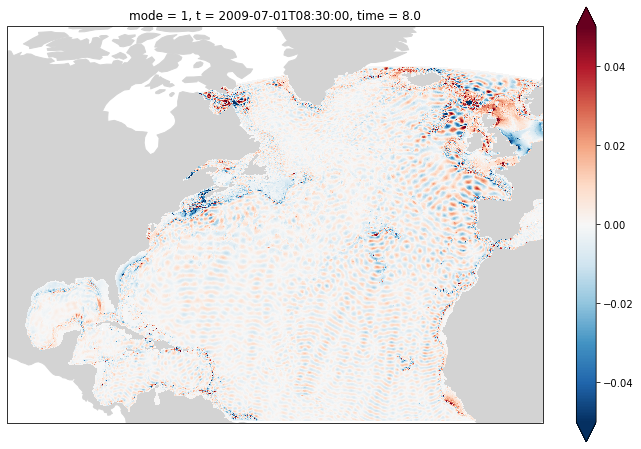

In [11]:
%%time
#map_proj = ccrs.LambertConformal(central_longitude=-28, central_latitude=39)
map_proj = ccrs.Robinson(central_longitude=-28)
norm = mpl.colors.Normalize(vmin=-.05, vmax=.05)
cmap = "RdBu_r"

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=map_proj)
#ax.coastlines()
#gl = ax.gridlines()
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.set_extent([-100, 2, 6, 68])
p = da_harmo.real.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                     x="llon", y="llat", 
                                    norm=norm, cmap=cmap)
#ax.set_aspect('equal', 'box-forced') # this raises an error


In [12]:
fig.savefig("figures/global_modal_{}_harmo_{}.png".format(var,ladate), 
            dpi=200, bbox_inches="tight")